In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [3]:
tfds.list_builders()

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# 將train Data重新分成9:1等分，分別分給train data, valid data
train_split, valid_split = ['train[:90%]', 'train[90%:]']
# 取得訓練數據，並順便讀取data的資訊
train_data, info = tfds.load("cifar10", split=train_split, with_info=True)
# 取得驗證數據
valid_data = tfds.load("cifar10", split=valid_split)
# 取得測試數據
test_data = tfds.load("cifar10", split="test")

In [5]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='C:\\Users\\9527\\tensorflow_datasets\\cifar10\\3.0.2',
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features f

In [6]:
labels_dict = dict(enumerate(info.features['label'].names))
labels_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [7]:
# 建立一個dict用來計數每個類別標籤數量
train_dict = {}
# 讀取整個訓練資料集
for data in train_data:
    # 將讀取到的label轉乘numpy格式
    label = data['label'].numpy()
    # 以label沒dict的key，取出dict中的值+1，如果key在dict中沒有值預設為0
    train_dict[label] = train_dict.setdefault(label, 0) + 1
    # train_dict.setdefault(label, 0) + 1
print(train_dict)

{7: 4500, 8: 4456, 4: 4497, 6: 4505, 5: 4503, 2: 4522, 9: 4453, 3: 4526, 0: 4530, 1: 4508}


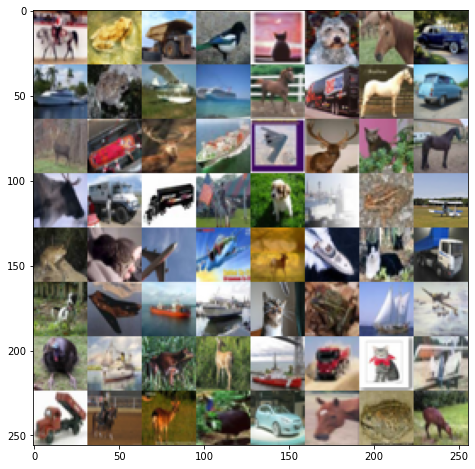

In [8]:
# 建立一個顯示影像的陣列
output = np.zeros((32 * 8, 32 * 8, 3), dtype=np.uint8)
row = 0
# 每一次取8比資料，共取8次，所以總共取得64比資料
for data in train_data.batch(8).take(8):
    # 將取得的8比堆疊起來，放入顯示影像陣列第N列中
    output[:, row*32:(row+1)*32] = np.vstack(data['image'].numpy())
    row += 1
# 設定顯示視窗大小
plt.figure(figsize=(8, 8))
# 顯示影像
plt.imshow(output)

In [9]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小
train_num = int(info.splits['train'].num_examples / 10) * 9  # 訓練資料數量

train_data = train_data.shuffle(train_num)  # 打散資料集
# 載入前面的資料愈處理function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [11]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(10, activation='softmax')(x) 
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()  # 顯示網路架構

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0   

In [12]:
model_dir = 'lab4-logs/models'  # 設定儲存權重目錄
os.makedirs(model_dir)  # 創建儲存權重目錄

In [13]:
# 將訓練記錄，存成TensorBoard的紀錄檔
log_dir = os.path.join('lab4-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir='lab4-logs/model-1')
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

In [14]:
model_1.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [15]:
history_1 = model_1.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 6s 7ms/step - loss: 2.1025 - categorical_accuracy: 0.2039 - val_loss: 1.8155 - val_categorical_accuracy: 0.3300
Epoch 2/100
704/704 [==============================] - 4s 5ms/step - loss: 1.8595 - categorical_accuracy: 0.3209 - val_loss: 1.7962 - val_categorical_accuracy: 0.3422
Epoch 3/100
704/704 [==============================] - 4s 5ms/step - loss: 1.7847 - categorical_accuracy: 0.3566 - val_loss: 1.7439 - val_categorical_accuracy: 0.3732
Epoch 4/100
704/704 [==============================] - 4s 5ms/step - loss: 1.7263 - categorical_accuracy: 0.3847 - val_loss: 1.6495 - val_categorical_accuracy: 0.4060
Epoch 5/100
704/704 [==============================] - 4s 5ms/step - loss: 1.6806 - categorical_accuracy: 0.3993 - val_loss: 1.6685 - val_categorical_accuracy: 0.4000
Epoch 6/100
704/704 [==============================] - 4s 5ms/step - loss: 1.6536 - categorical_accuracy: 0.4126 - val_loss: 1.5989 - val_categorical_accuracy: 0.430

Epoch 50/100
704/704 [==============================] - 4s 5ms/step - loss: 1.0048 - categorical_accuracy: 0.6317 - val_loss: 1.9263 - val_categorical_accuracy: 0.4410
Epoch 51/100
704/704 [==============================] - 4s 6ms/step - loss: 0.9970 - categorical_accuracy: 0.6323 - val_loss: 2.0877 - val_categorical_accuracy: 0.4312
Epoch 52/100
704/704 [==============================] - 4s 5ms/step - loss: 0.9701 - categorical_accuracy: 0.6461 - val_loss: 2.0132 - val_categorical_accuracy: 0.4344
Epoch 53/100
704/704 [==============================] - 4s 5ms/step - loss: 0.9873 - categorical_accuracy: 0.6398 - val_loss: 1.9230 - val_categorical_accuracy: 0.4390
Epoch 54/100
704/704 [==============================] - 4s 5ms/step - loss: 0.9772 - categorical_accuracy: 0.6422 - val_loss: 2.0217 - val_categorical_accuracy: 0.4294
Epoch 55/100
704/704 [==============================] - 4s 5ms/step - loss: 0.9590 - categorical_accuracy: 0.6507 - val_loss: 2.0903 - val_categorical_accuracy:

Epoch 99/100
704/704 [==============================] - 4s 5ms/step - loss: 0.6341 - categorical_accuracy: 0.7731 - val_loss: 2.7368 - val_categorical_accuracy: 0.4224
Epoch 100/100
704/704 [==============================] - 4s 5ms/step - loss: 0.5743 - categorical_accuracy: 0.7948 - val_loss: 2.9308 - val_categorical_accuracy: 0.4220


In [16]:
loss, acc = model_1.evaluate(test_data)
print('\nModel-1 Accuracy: {}%'.format(acc))

157/157 [==============================] - 1s 3ms/step - loss: 2.8326 - categorical_accuracy: 0.4315

Model-1 Accuracy: 0.43149998784065247%


In [17]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()  # 顯示網路架構

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          7379

In [18]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab4-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

In [19]:
model_2.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [20]:
history_2 = model_2.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 14s 13ms/step - loss: 2.0335 - categorical_accuracy: 0.2370 - val_loss: 1.4499 - val_categorical_accuracy: 0.4740
Epoch 2/100
704/704 [==============================] - 8s 12ms/step - loss: 1.5311 - categorical_accuracy: 0.4422 - val_loss: 1.2729 - val_categorical_accuracy: 0.5422
Epoch 3/100
704/704 [==============================] - 8s 12ms/step - loss: 1.3436 - categorical_accuracy: 0.5222 - val_loss: 1.1809 - val_categorical_accuracy: 0.5752
Epoch 4/100
704/704 [==============================] - 8s 12ms/step - loss: 1.2116 - categorical_accuracy: 0.5688 - val_loss: 1.0792 - val_categorical_accuracy: 0.6012
Epoch 5/100
704/704 [==============================] - 8s 12ms/step - loss: 1.1250 - categorical_accuracy: 0.6034 - val_loss: 1.0193 - val_categorical_accuracy: 0.6234
Epoch 6/100
704/704 [==============================] - 8s 12ms/step - loss: 1.0369 - categorical_accuracy: 0.6312 - val_loss: 0.9520 - val_categorical_accuracy

704/704 [==============================] - 8s 12ms/step - loss: 0.1738 - categorical_accuracy: 0.9442 - val_loss: 1.6885 - val_categorical_accuracy: 0.7228
Epoch 50/100
704/704 [==============================] - 8s 12ms/step - loss: 0.1487 - categorical_accuracy: 0.9533 - val_loss: 1.7952 - val_categorical_accuracy: 0.7168
Epoch 51/100
704/704 [==============================] - 8s 12ms/step - loss: 0.1341 - categorical_accuracy: 0.9540 - val_loss: 1.9082 - val_categorical_accuracy: 0.7278
Epoch 52/100
704/704 [==============================] - 8s 12ms/step - loss: 0.1301 - categorical_accuracy: 0.9572 - val_loss: 1.8796 - val_categorical_accuracy: 0.7364
Epoch 53/100
704/704 [==============================] - 8s 12ms/step - loss: 0.1288 - categorical_accuracy: 0.9596 - val_loss: 2.0070 - val_categorical_accuracy: 0.7324
Epoch 54/100
704/704 [==============================] - 8s 12ms/step - loss: 0.1510 - categorical_accuracy: 0.9519 - val_loss: 1.7729 - val_categorical_accuracy: 0.7194

704/704 [==============================] - 8s 12ms/step - loss: 0.1092 - categorical_accuracy: 0.9685 - val_loss: 2.4560 - val_categorical_accuracy: 0.7248
Epoch 98/100
704/704 [==============================] - 8s 12ms/step - loss: 0.0818 - categorical_accuracy: 0.9754 - val_loss: 2.5239 - val_categorical_accuracy: 0.7090
Epoch 99/100
704/704 [==============================] - 8s 12ms/step - loss: 0.1159 - categorical_accuracy: 0.9644 - val_loss: 2.4426 - val_categorical_accuracy: 0.7240
Epoch 100/100
704/704 [==============================] - 8s 12ms/step - loss: 0.0999 - categorical_accuracy: 0.9710 - val_loss: 2.4137 - val_categorical_accuracy: 0.7174


In [21]:
loss, acc = model_2.evaluate(test_data)
print('\nModel-2 Accuracy: {}%'.format(acc))

157/157 [==============================] - 1s 5ms/step - loss: 2.3195 - categorical_accuracy: 0.7265

Model-2 Accuracy: 0.7264999747276306%


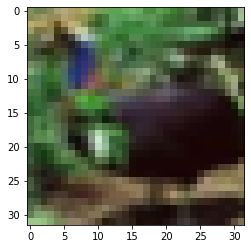

In [22]:
x = 3
y = 7
image_test = output[y*32:(y+1)*32, x*32:(x+1)*32, :]
plt.imshow(image_test)

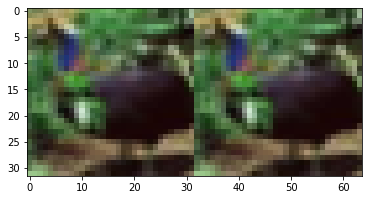

In [23]:
def flip(x):
    """
    flip image(翻轉影像)
    """
    x = tf.image.random_flip_left_right(x)  # 隨機左右翻轉影像
    return x

image_2 = flip(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

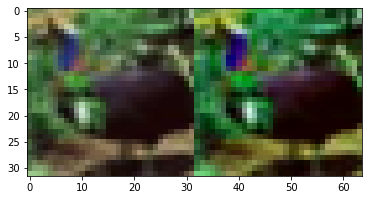

In [24]:
def color(x):
    """
     Color change(改變顏色)
    """
    x = tf.image.random_hue(x, 0.08)  # 隨機調整影像色調
    x = tf.image.random_saturation(x, 0.6, 1.6)  # 隨機調整影像飽和度
    x = tf.image.random_brightness(x, 0.05)  # 隨機調整影像亮度
    x = tf.image.random_contrast(x, 0.7, 1.3)  # 隨機調整影像對比度
    return x


image_2 = color(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

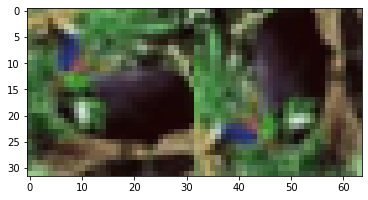

In [25]:
def rotate(x):
    """
    Rotation image(影像旋轉)
    """
    # 隨機選轉n次(通過minval和maxval設定n的範圍)，每次選轉90度
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

image_2 = rotate(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

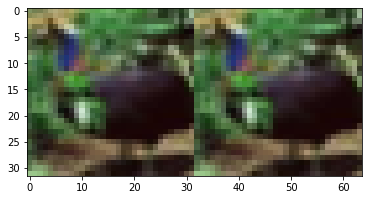

In [26]:
def zoom(x, scale_min=0.6, scale_max=1.4):
    """
    Zoom Image(影像縮放)
    """
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)  # 隨機縮放比例
    sh = h * scale  # 縮放後影像長度
    sw = w * scale  # 縮放後影像寬度
    x = tf.image.resize(x, (sh, sw))  # 影像縮放
    x = tf.image.resize_with_crop_or_pad(x, h, w)  # 影像裁減和填補
    return x

image_2 = zoom(image_test)
# 因為處理後影像會變成float型態，所以需轉換回來不然顯示時會出現問題
image_2 = tf.cast(image_2, dtype=tf.uint8)
image = np.hstack((image_test, image_2))  # 將原始圖和處理後水平合併
plt.imshow(image)

In [27]:
train_data = tfds.load("cifar10", split=train_split)

In [28]:
def parse_aug_fn(dataset):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(dataset['image'], tf.float32) / 255.  # 影像標準化
    x = flip(x)  # 隨機水平翻轉
    # 觸發顏色轉換機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x)
    # 觸發影像旋轉機率0.25%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # 觸發影像縮放機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    # 將輸出標籤轉乘One-hot編碼
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [29]:
# 打散資料集
train_data = train_data.shuffle(train_num)
# 載入預處理「parse_aug_fn」function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟（暫存空間為自動調整模式）
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

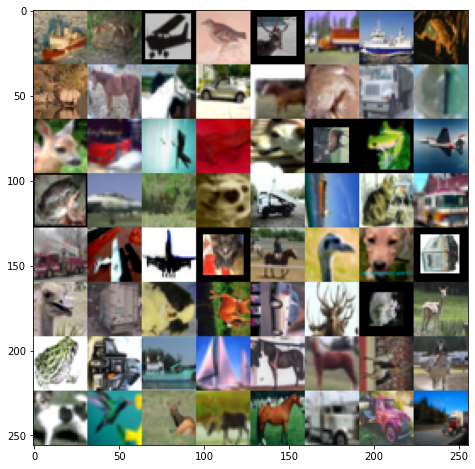

In [30]:
# 由於前面已經將train_data batch size設定為64，所以取一次資料就有64筆
for images, labels in train_data.take(1):
    images = images.numpy()
# 建立一個顯示影像的陣列
output = np.zeros((32 * 8, 32 * 8, 3))
# 將64筆資料分別放入顯示影像的陣列
for i in range(8):
    for j in range(8):
        output[i*32:(i+1)*32, j*32:(j+1)*32, :] = images[i*8+j]
plt.figure(figsize=(8, 8))
# 顯示影像
plt.imshow(output)

In [31]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_3 = keras.Model(inputs, outputs, name='model-3')
model_3.summary()  # 顯示網路架構

Model: "model-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          7379

In [32]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab4-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

In [33]:
model_3.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [34]:
history_3 = model_3.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 10s 14ms/step - loss: 2.1225 - categorical_accuracy: 0.1911 - val_loss: 1.7199 - val_categorical_accuracy: 0.3714
Epoch 2/100
704/704 [==============================] - 9s 12ms/step - loss: 1.8510 - categorical_accuracy: 0.3209 - val_loss: 1.5039 - val_categorical_accuracy: 0.4480
Epoch 3/100
704/704 [==============================] - 8s 12ms/step - loss: 1.6957 - categorical_accuracy: 0.3820 - val_loss: 1.3596 - val_categorical_accuracy: 0.5134
Epoch 4/100
704/704 [==============================] - 8s 12ms/step - loss: 1.6087 - categorical_accuracy: 0.4210 - val_loss: 1.2373 - val_categorical_accuracy: 0.5542
Epoch 5/100
704/704 [==============================] - 8s 12ms/step - loss: 1.5315 - categorical_accuracy: 0.4530 - val_loss: 1.2539 - val_categorical_accuracy: 0.5508
Epoch 6/100
704/704 [==============================] - 8s 12ms/step - loss: 1.4668 - categorical_accuracy: 0.4745 - val_loss: 1.1191 - val_categorical_accuracy

704/704 [==============================] - 8s 12ms/step - loss: 0.9059 - categorical_accuracy: 0.6974 - val_loss: 0.6813 - val_categorical_accuracy: 0.7690
Epoch 50/100
704/704 [==============================] - 8s 12ms/step - loss: 0.8916 - categorical_accuracy: 0.6968 - val_loss: 0.6719 - val_categorical_accuracy: 0.7700
Epoch 51/100
704/704 [==============================] - 8s 12ms/step - loss: 0.8961 - categorical_accuracy: 0.7007 - val_loss: 0.7020 - val_categorical_accuracy: 0.7690
Epoch 52/100
704/704 [==============================] - 8s 12ms/step - loss: 0.8910 - categorical_accuracy: 0.7016 - val_loss: 0.6774 - val_categorical_accuracy: 0.7742
Epoch 53/100
704/704 [==============================] - 8s 12ms/step - loss: 0.8820 - categorical_accuracy: 0.7034 - val_loss: 0.6662 - val_categorical_accuracy: 0.7774
Epoch 54/100
704/704 [==============================] - 8s 12ms/step - loss: 0.8928 - categorical_accuracy: 0.7042 - val_loss: 0.7048 - val_categorical_accuracy: 0.7660

704/704 [==============================] - 8s 12ms/step - loss: 0.7685 - categorical_accuracy: 0.7426 - val_loss: 0.6676 - val_categorical_accuracy: 0.7872
Epoch 98/100
704/704 [==============================] - 8s 12ms/step - loss: 0.7821 - categorical_accuracy: 0.7413 - val_loss: 0.6595 - val_categorical_accuracy: 0.7914
Epoch 99/100
704/704 [==============================] - 9s 12ms/step - loss: 0.7703 - categorical_accuracy: 0.7430 - val_loss: 0.6693 - val_categorical_accuracy: 0.7860
Epoch 100/100
704/704 [==============================] - 8s 12ms/step - loss: 0.7908 - categorical_accuracy: 0.7372 - val_loss: 0.6660 - val_categorical_accuracy: 0.7828


In [35]:
loss, acc = model_3.evaluate(test_data)
print('\nModel-3 Accuracy: {}%'.format(acc))

157/157 [==============================] - 1s 4ms/step - loss: 0.6516 - categorical_accuracy: 0.7876

Model-3 Accuracy: 0.7875999808311462%


In [36]:
model_1.load_weights('lab4-logs/models/Best-model-1.hdf5')
model_2.load_weights('lab4-logs/models/Best-model-2.hdf5')
model_3.load_weights('lab4-logs/models/Best-model-3.hdf5')
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

157/157 [==============================] - 1s 4ms/step - loss: 0.6377 - categorical_accuracy: 0.8018


In [37]:
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

157/157 [==============================] - 1s 4ms/step - loss: 0.6377 - categorical_accuracy: 0.8018


In [38]:
loss = [loss_1, loss_2, loss_3]  
acc = [acc_1, acc_2, acc_3]

dict = {"Loss": loss,  
        "Accuracy": acc}

df = pd.DataFrame(dict)
df

,Loss,Accuracy
0,1.575970,0.4614
1,1.989030,0.7402
2,0.637675,0.8018
